In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Serie de tiempo para Gasolina Regular

## Importacion

### inicio, fin y frecuencia

In [3]:
# Carga de datos y serie univariante
df_imp = pd.read_csv('./data/importacion.csv', parse_dates=['Fecha'], dayfirst=True)
df_imp.set_index('Fecha', inplace=True)
ts_imp_reg = df_imp['Gasolina regular']

# Inicio, fin y frecuencia
print("Inicio:", ts_imp_reg.index.min())
print("Fin:   ", ts_imp_reg.index.max())
print("Frecuencia inferida:", pd.infer_freq(ts_imp_reg.index))

Inicio: 2001-01-01 00:00:00
Fin:    2024-01-12 00:00:00
Frecuencia inferida: None


### Grafico de la serie 

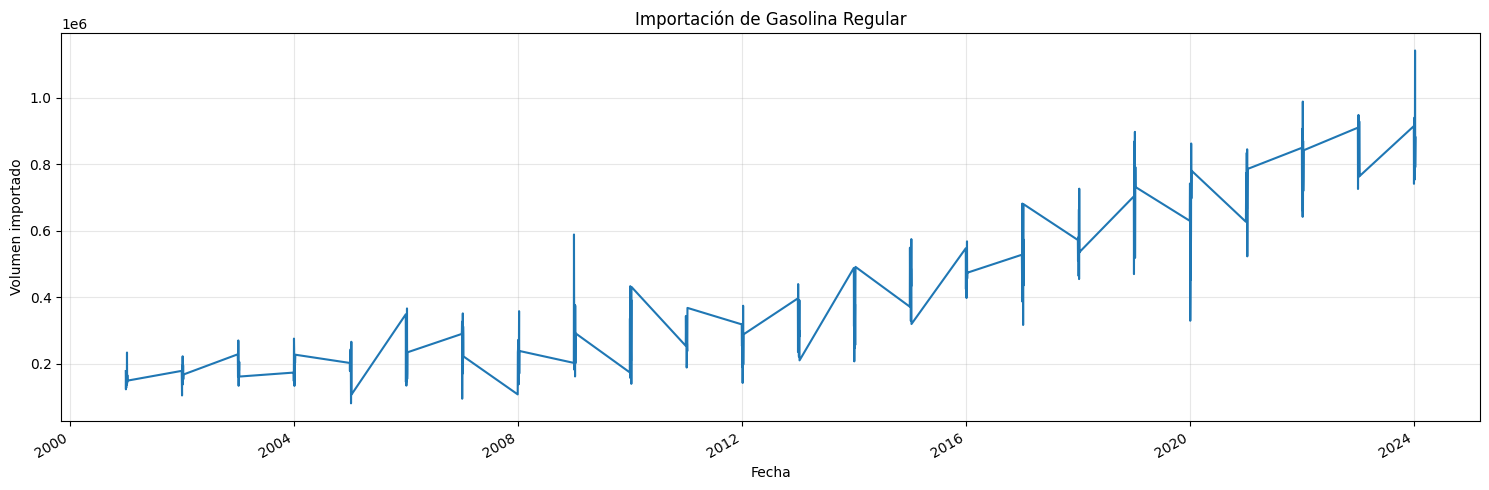

In [5]:
plt.figure(figsize=(15,5))
ts_imp_reg.plot()
plt.title('Importación de Gasolina Regular')
plt.xlabel('Fecha')
plt.ylabel('Volumen importado')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

###  Descomposición de la serie y discusión de estacionariedad

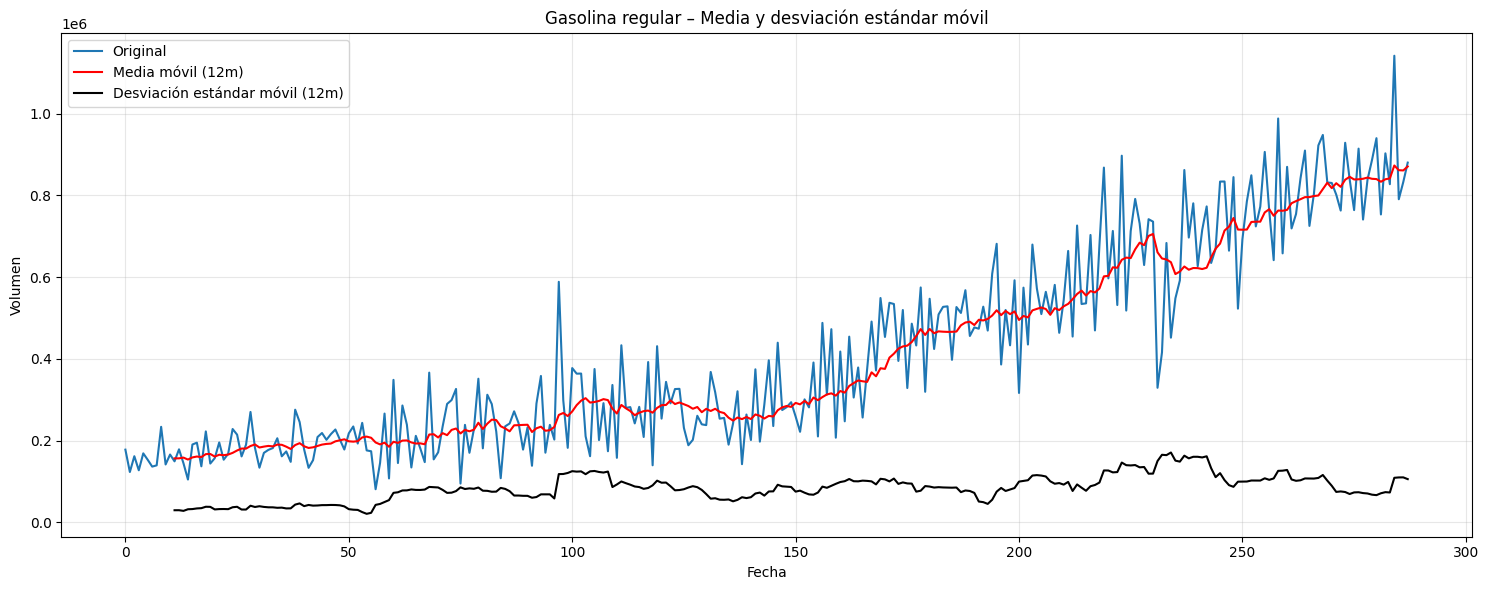 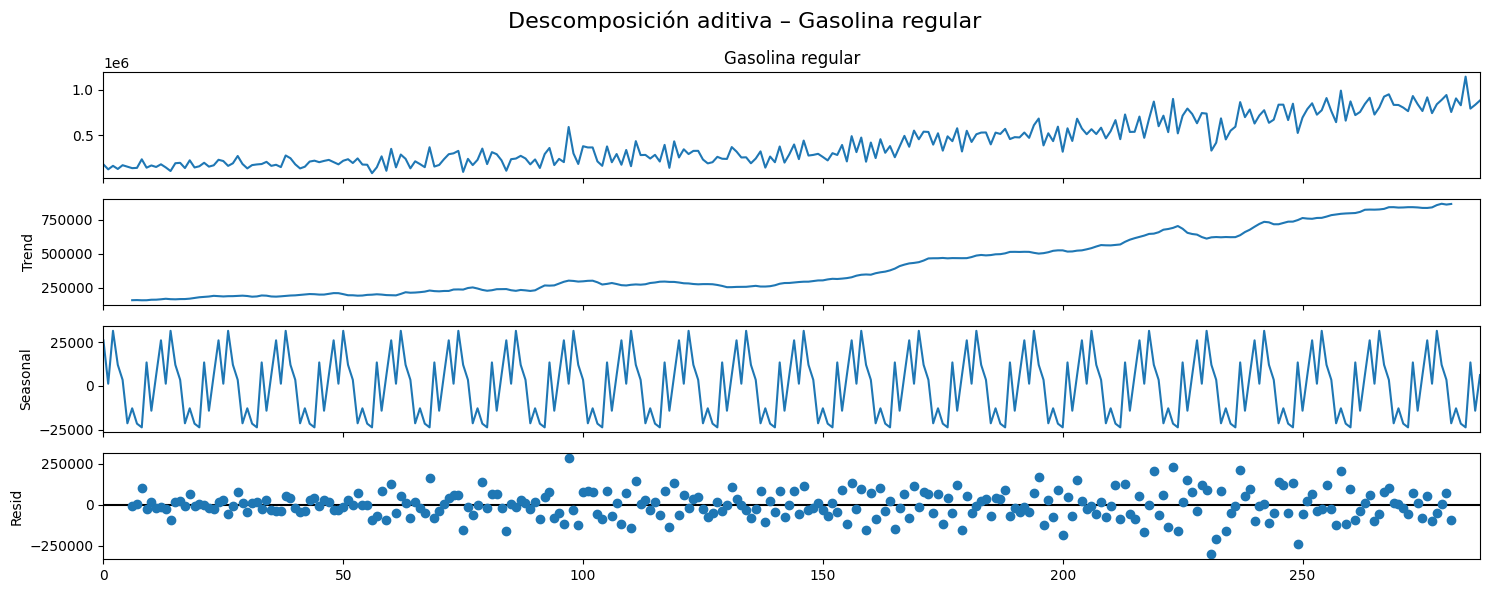

1. Tendencia (media móvil y componente trend)

    - La línea de media móvil (roja) crece de manera clara y sostenida a lo largo de toda la serie.

    - El componente Trend de la descomposición muestra un comportamiento muy similar: arranca en niveles bajos y sube constantemente hasta los valores máximos recientes.

    - La media no es constante: existe una fuerte tendencia alcista, por lo que la serie no es estacionaria en la media.

2. Estacionalidad (componente seasonal)

    - El patrón estacional repite un pico y un valle cada 12 meses, con picos anuales más pronunciados en ciertos periodos.

    - La forma de la estacionalidad es bastante consistente en toda la serie, lo cual indica un ciclo bien definido.

3. Varianza (desviación estándar móvil y residuos)

    - La desviación estándar móvil (negra) aumenta conforme avanza el tiempo: antes era pequeña, y en los últimos años crece hasta niveles muy altos.

    - En el gráfico de residuos (Resid), la dispersión alrededor de cero es pequeña al inicio y se vuelve mucho más amplia hacia el final.

    - La varianza no es constante: al crecer la amplitud de las fluctuaciones, la serie no es estacionaria en la varianza.


*Conclusiones*
- La serie muestra una tendencia claramente ascendente (tanto la media móvil como el componente Trend crecen de manera sostenida).

- Existe un patrón estacional anual definido.

- La varianza no es constante (crece/decrece con el tiempo).

- Por lo tanto, la serie de importación de gasolina regular tiene tendencia y no es estacionaria ni en media ni en varianza.

